# 7章 畳み込みニューラルネットワーク(convolutional neural network: CNN)
* CNNは画像認識や音声認識などいたるところで使われている
* 画像認識のコンペでは，ほとんどすべてがCNNベースである

## 7.1 全体の構造
* CNNもこれまでのニューラルネットワークと同じくレイヤを組み合わせて作る
* CNNでは「Convolutionレイヤ（畳み込み層）」と「Poolingレイヤ（プーリング層）」が加わる
* これまでのネットワークでは隣接する層の全ニューロン間が結合されていた（全結合：fully-connected）
  * 全結合層はAffineレイヤとして実装した
  * Affineレイヤの後にReLUを接続し，それを何回か繰り返したのち，最終出力では Affineレイヤ$\rightarrow$Softmaxレイヤの順で出力する
* CNNの場合の構成
  * Convolutionレイヤ$\rightarrow$ReLUレイヤ$\rightarrow$Poolingレイヤの順で接続し，それを何回か繰り返し，最終出力では全結合ネットワークと同様にAffineレイヤ$\rightarrow$Softmaxレイヤで出力する
  * Poolingレイヤは省略されることもある

## 7.2 畳み込み層
### 7.2.1 全結合層の問題点
* 全結合層のニューラルネットワークではAffineレイヤを使用した
* Affineレイヤの問題点はデータの形状が無視されること
  * 例えば，画像は本来「縦，横，チャネル」の方向の広がりを持った3次元形状のデータである
  * Affineレイヤに入力するためにはデータを1次元データに変換する必要がある
  * 画像の場合，隣接するピクセル間に類似性などがあったりするなどなんらかのパターンが含まれている
  * Affineレイヤはパターンを無視して入力データを扱い，パターンの情報を生かすことがない
* 畳み込み層は形状を維持する
  * 画像の場合では入力データを3次元データとして受け取り，3次元データとして次の層に出力する
    * CNNでは畳み込み層の入出力データのことを特徴マップ（feature map），入力特徴マップ，出力特徴マップのように呼ぶ場合がある
  * そのため，形状やパターンのデータをうまく扱える可能性が残る

### 7.2.2 畳み込み演算
* 畳み込み層では畳み込み演算を行う
  * 畳み込み演算は画像処理でいうところのフィルター演算に相当する
* 畳み込み演算は，「入力データ」に対して「フィルター」を適用する
  * 入力データおよびフィルタはともに縦横の形状をもつ
  * フィルタは「カーネル」と呼ばれることもある
* 畳み込み演算は入力データに対してフィルターのウィンドウを一定間隔でスライドさせながら適用させる
  * それぞれの場所でフィルタの要素と入力の対応する要素を乗算し，その和を計算する（積和演算）
  * その和の値を出力の対応する場所へ格納する
  * このプロセスをすべての場所で行うことで畳み込み演算の出力を得る
* Affineレイヤでは重みパラメータの他にバイアスが存在した．
* CNNの場合，フィルタのパラメータが重みに対応する．またバイアスも存在する
  * バイアスは(1,1)のデータで，フィルタ適用後の結果の全要素にそれぞれ加算される

### 7.2.3 パディング(padding)
* 出力サイズを調整するために，入力データの周囲に固定のデータを埋めること
  * 例えば「幅1のパディングを適用する」とは，周囲を幅1ピクセルの0で埋める
* パディングすると出力は大きくなる

### 7.2.4 ストライド(stride)
* フィルターを適用する位置の間隔
* 例えば，ストライドを2にすると，積和演算のためのフィルタは2要素ずつ移動する
* ストライドを大きくすると出力は小さくなる
* サイズの関係: $OH, OW$の計算結果は整数にならなければならないことに注意（割り切れること）
  * 入力サイズ $(H,W)$
  * フィルターサイズ $(FH,FW)$
  * 出力サイズ $(OH, OW)$
  * パディング $P$
  * ストライド $S$
$$OH=\frac{H+2P-FH}{S}+1 \\
OW=\frac{W+2P-FW}{S}+1$$

### 7.2.5 3次元データの畳み込み演算
* 画像の場合は縦横だけでなくチャネル方向も合わせた3次元で扱う必要がある
* チャネル方向も合わせた3次元データに対する畳み込み演算を考える
* チャネルごとに特徴マップがある場合，チャネルごとに入力データとフィルタの畳み込み演算を行い，チャネルごとの結果を加算して一つの出力を計算する
* 注意点：入力データとフィルタのチャネル数は同じにする
  * フィルタのサイズは自由に設定できる

### 7.2.6 ブロックで考える
* 前節では複数チャネル（チャネル数 $C$）からなる画像データ(サイズ $H \times W$)に，それと同じチャネル数($C$)のフィルタ(サイズ $FH \times FW$)を適用して一つの（チャネルが1の）出力特徴マップ(サイズ $OH \times OW$)を得た
* 複数チャネル($FN$個)からなる出力特徴マップを得るにはどうしたら良いか $\rightarrow$ 複数($FN$個)のフィルタを用いる
* 畳み込み演算のフィルタはフィルタの個数$(FN)$も考慮すると4次元のデータとなる
  * (出力チャネル数，入力チャネル数，出力縦，出力横)
    * チャネル数3, サイズ5$\times$5 のフィルタが20個ある場合は $(20, 3, 5, 5)$
* 畳み込み演算のバイアスは出力チャネル数を考慮すると (FN, 1, 1) となる
  * チャネルごとに同じバイアス値がチャネル内の全要素に加算される
* まとめ
  * 入力特徴マップ $(C, H, W)$
  * フィルタ $(FN, C, FH, FW)$
  * バイアス $(FN, 1, 1)$
  * 出力特徴マップ $(FN, OH, OW)$

### 7.2.7 バッチ処理
* バッチを考慮しない場合の入力特徴マップは $(C, H, W)$，出力は $(FN, OH, OW)$
* バッチ処理を考慮する場合，複数($N$個)のデータをまとめて処理することになり，それが畳み込み層へ入力される
* したがってバッチ処理を考慮すると，レイヤの特徴マップは4次元になる：入力 $(N, C, H, W)$ および出力 $(N, FN, OH, OW)$

## 7.3 プーリング層
* プーリングは縦・横方向の空間を小さくする演算
* 複数の要素を一つに集約するような処理を行うことで，空間を小さくする
* 最大値をとるMaxプーリングや平均をとるAverageプーリングなどがある
  * ここではMaxプーリングのみを使用する

### 7.3.1 プーリング層の特徴
* 学習するパラメータがない
  * 入力データだけを使って行う処理なので，学習が必要ない
* チャネル数は変化しない
  * チャネルごとに処理を行い，まとめないためチャネル数は変わらない
* 微小な位置変化に対してロバストである
  * 多少ずれても同じような結果となる（必ずしも同じにはならないことに注意）

In [68]:
# coding: utf-8
import numpy as np
import sys, os
sys.path.append(os.pardir)
sys.path.append(os.pardir + "/deep_learning_from_scratch")

import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

## 7.4 Convolution/Poolingレイヤの実装
* レイヤなのでこれまでと同様，forward と backward というメソッドを持つ

### 7.4.1 4次元配列
* CNNの各層を流れるデータは（バッチおよびチャネルを考慮して）4次元データである

In [5]:
# 適当な4次元配列の生成
# バッチサイズ10，チャネル1，縦横それぞれ28のデータとして生成してみる
x = np.random.rand(10, 1, 28, 28)
# 形状を確認
print(x.shape)

# 一つ目のデータにアクセス
#print(x[0])
# 一つ目の1チャネル目のデータにアクセス
print(x[0][0])

(10, 1, 28, 28)
[[  2.19232042e-01   5.90861140e-01   2.63953204e-01   4.18263379e-01
    6.08842501e-01   6.79750881e-01   9.91308545e-01   4.34468324e-01
    7.68900295e-01   3.15335981e-01   6.94250983e-01   6.95741022e-01
    3.78626632e-02   6.45433312e-01   1.67335035e-01   5.42430911e-01
    1.92928840e-01   8.97749645e-01   1.05179618e-01   7.06824953e-02
    7.54502595e-01   2.32788920e-01   7.20376113e-01   1.29690383e-01
    3.92271349e-01   9.63076902e-01   2.00461682e-01   4.10595885e-01]
 [  6.16314215e-02   7.66184999e-01   4.17424746e-01   5.31912690e-01
    4.29193874e-01   3.29056436e-01   4.52644242e-01   1.34644337e-01
    3.62031826e-01   6.61525888e-01   9.72074578e-01   9.77747470e-01
    9.37942721e-01   5.13356046e-01   8.15957317e-01   2.01714083e-01
    1.96431033e-01   5.02608040e-01   8.94071209e-02   6.07131982e-01
    9.72602574e-01   4.36672643e-01   8.46574074e-01   5.24599400e-01
    8.12844564e-01   6.88401405e-01   7.92341390e-01   7.21485930e-01]
 [

### 7.4.2 im2col による展開
* 畳み込み演算を愚直に実装するとforを多段にネストしたコードになるが，Numpyだとパフォーマンス上問題になる
* for の代わりに im2col という関数を使用する
* ストライドが小さい場合，畳み込みの各領域は重なりを持つことから，結果の行列は重複要素を持つことになる
  * メモリ使用量が増大するが，既存の線形代数ライブラリを有効活用することができる
* 既存のCaffeやChainerなどのフレームワークでも同様の関数が用意されていて，畳み込み層の実装で用いられている

In [49]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    
    # 出力画像サイズの計算
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    
    # 入力画像の縦横(3番目と4番目の軸)の両端にpad個ずつ定数(0)をパディング
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    # 展開後の入力データを表す行列 col の生成
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    # 入力画像の要素をコピー
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    # 軸の順番の入れ替えおよび2次元配列化．
    # 2次元配列の最初の軸は出力データに関するもの，後の軸は積和計算に関するもの．
    #   行数：（データ数＊出力縦＊出力横）
    #   列数：（フィルタ縦＊フィルタ横＊チャネル数）
    # 2次元配列化により畳み込みの積和演算が，内積演算で処理できる．
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


In [10]:
# numpy.pad 関数の動作確認
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
x = np.random.rand(10, 1, 28, 28)
print(x.shape)
pad = 0
img = np.pad(x, [(0,1), (1,0), (pad, pad), (pad, pad)], 'constant')
print(img.shape)

(10, 1, 28, 28)
(11, 2, 28, 28)


In [48]:
# numpy.transpose の動作確認
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.transpose.html
# 要素が全て1の3次元配列を生成し，形状を確認
x = np.ones((2,1,3))
print(x.shape)

# 特定の要素のみ値を変えてみる
x[0][0][2] = 5
x[1][0][1] = 3
print(x)

# 形状を変換する．3番目の軸を1番目に，1番目の軸を2番目に，2番目の軸を3番目に
x2 = x.transpose(2,0,1)
print("x2.shape = " + str(x2.shape))
print("x2 = " + str(x2))

(2, 1, 3)
[[[ 1.  1.  5.]]

 [[ 1.  3.  1.]]]
x2.shape = (3, 2, 1)
x2 = [[[ 1.]
  [ 1.]]

 [[ 1.]
  [ 3.]]

 [[ 5.]
  [ 1.]]]


### 7.4.3 Convolutionレイヤの実装


In [51]:
# im2colを使ってみる
# 入力画像サイズ(7,7)，チャネル数3，データ数1
x1 = np.random.rand(1, 3, 7, 7)
# フィルタのサイズ(5,5), パディングなし，ストライド1
col1 = im2col(x1, 5, 5, stride=1, pad=0)
# 形状を出力．(データ数*出力縦*出力横，チャネル数*フィルタ縦*フィルタ横) となるはず．
# 出力画像サイズが(3,3)になるため，その場合，col1のサイズは(1*3*3, 3*5*5)=(9,75)
print(col1.shape)

# データ10個とする場合．単純に結果の行数が10倍になる
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [60]:
# com2im の実装(common/utils.pyより)
# 畳み込みレイヤおよびPoolingレイヤの逆伝播で使用する
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    
    Returns
    -------
    
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
    
    return img[:, :, pad:H + pad, pad:W + pad]

In [57]:
# 畳み込み層の実装
class Convolution:
    # W: フィルタ．(データ数，チャネル数，フィルタ高さ，フィルタ幅)の4次元配列
    # b: バイアス．データ数の1次元配列
    # stride: ストライド（既定値1）
    # pad: パディング幅(既定値0)
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    # 順方向処理
    # x: 入力データ．（データ数，チャネル数，高さ，幅）の4次元配列
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        
        # 入力画像からフィルタリング用の2次元配列を生成
        # 形状は（データ数＊出力高さ＊出力幅，チャネル数＊フィルタ高さ＊フィルタ幅）
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルタの展開．（1個あたりFH*FW*Cのサイズの列ベクトルがFN個並んだ行列になる）
        col_W = self.W.reshape(FN, -1).T
        
        out = np.dot(col, col_W) + self.b
        # 4次元配列に戻し，軸の順序を入れ替え．4番目の軸(フィルタ個数)を2番目にもってくる．
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    # 逆伝播
    # Affineレイヤとほぼ同様
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx


### 7.4.4 Poolingレイヤの実装
* Convolutionレイヤと同様にim2colを使って入力データを展開する
* プーリングの場合はチャンネル方向には独立であるため，プーリングの適用領域はチャンネルごとに独立して展開する
* 展開後は，展開した行列に対して，行ごとに最大値を計算し，適切な形状に整形するだけ
* Poolingレイヤ実装の流れ
  1. 入力データを展開する
  2. 行ごとに最大を求める
    * 最大値の計算には numpy.max 関数が利用できる．
  3. 適切な出力サイズに整形する
* 逆伝播は ReLUレイヤの説明が参考になる

In [59]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


## 7.5 CNNの実装

In [65]:
class SimpleConvNet:
    """単純なConvNet
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        
        self.last_layer = SoftmaxWithLoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)
        
        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])
        
        return grads
    
    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        
        return grads
    
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
    
    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        
        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.30021325023
=== epoch:1, train acc:0.292, test acc:0.238 ===
train loss:2.29902688662
train loss:2.29573785806
train loss:2.29132090512
train loss:2.28443787166
train loss:2.27731930979
train loss:2.27188798006
train loss:2.25066780577
train loss:2.22662988336
train loss:2.21985728801
train loss:2.18898422966
train loss:2.15551093298
train loss:2.11955375106
train loss:2.09381138115
train loss:2.04137533975
train loss:1.95798822867
train loss:1.98016265231
train loss:1.88217242596
train loss:1.80138353313
train loss:1.72946727153
train loss:1.66290192548
train loss:1.62201516592
train loss:1.43066079555
train loss:1.46062518971
train loss:1.30367811573
train loss:1.3514062911
train loss:1.11707860155
train loss:1.06562713111
train loss:1.0452380716
train loss:0.853711461108
train loss:0.941138015226
train loss:0.974256480723
train loss:0.941548362704
train loss:0.898196740482
train loss:0.740242954072
train loss:0.762782559955
train loss:0.679054576656
train loss:0.7917544

train loss:0.194350870256
train loss:0.206575327601
train loss:0.158345131486
train loss:0.174219238535
train loss:0.200435595299
train loss:0.357157462576
train loss:0.17894623568
train loss:0.199384800303
train loss:0.179782959948
train loss:0.134626410531
train loss:0.24596562802
train loss:0.187480310793
train loss:0.181823414123
train loss:0.169820461993
train loss:0.280267853202
train loss:0.193773506511
train loss:0.322272681509
train loss:0.187646864309
train loss:0.173156026101
train loss:0.154970838923
train loss:0.20077222881
train loss:0.170482406511
train loss:0.26681122806
train loss:0.329179898436
train loss:0.331388266189
train loss:0.111868237489
train loss:0.202359247496
train loss:0.200132321436
train loss:0.143194287269
train loss:0.241088877853
train loss:0.16265218288
train loss:0.28490803768
train loss:0.154673882531
train loss:0.171500545421
train loss:0.195270936593
train loss:0.24264413462
train loss:0.200877785776
train loss:0.227248765842
train loss:0.168892

train loss:0.0348135394039
train loss:0.0834323088664
train loss:0.0703880674175
train loss:0.0727010692368
train loss:0.100592676724
train loss:0.145864835429
train loss:0.110337339703
train loss:0.16751647328
train loss:0.0598108567956
train loss:0.105170047684
train loss:0.0550653510835
train loss:0.131971810462
train loss:0.0824398606908
train loss:0.0870847482543
train loss:0.0697545314868
train loss:0.116036927071
train loss:0.112556441523
train loss:0.216744894434
train loss:0.208288229171
train loss:0.0774690584315
train loss:0.0533101646609
train loss:0.0597149961665
train loss:0.173585834922
train loss:0.0662131773167
train loss:0.122504597086
train loss:0.0255993263599
train loss:0.109514512168
train loss:0.182966046236
train loss:0.0956778819622
train loss:0.0700388130987
train loss:0.0995153355624
train loss:0.0366701203846
train loss:0.12908364192
train loss:0.120307788725
train loss:0.0721361376732
train loss:0.0895010375521
train loss:0.0493113725769
train loss:0.095045

train loss:0.0623613448766
train loss:0.101134488722
train loss:0.132940348068
train loss:0.054715209628
train loss:0.0986265444312
train loss:0.0447008574522
train loss:0.064990463991
train loss:0.0468695494443
train loss:0.0369711426599
train loss:0.0729068799903
train loss:0.0548102963814
train loss:0.0752329571145
train loss:0.0743747523823
train loss:0.0343985006001
train loss:0.0618709501871
train loss:0.0520403902792
train loss:0.0266293481793
train loss:0.0745911413499
train loss:0.102326923668
train loss:0.0326309871483
train loss:0.0602715149301
train loss:0.0513481159741
train loss:0.0746481257089
train loss:0.0991105495724
train loss:0.0518383496496
train loss:0.0485161589649
train loss:0.0476241392254
train loss:0.0550809107167
train loss:0.0755040271409
train loss:0.0758317634865
train loss:0.0405597165579
train loss:0.0370031202592
train loss:0.0643361646896
train loss:0.0342359346826
train loss:0.0347524371067
train loss:0.0741052881397
train loss:0.0269127877595
train 

train loss:0.134830028547
train loss:0.0118404187055
train loss:0.127902759246
train loss:0.0760515828804
train loss:0.0316460369298
train loss:0.0821634150254
train loss:0.100116768189
train loss:0.0837851048578
train loss:0.0573938847228
train loss:0.0874138763989
train loss:0.0491377595678
train loss:0.135132898608
train loss:0.0545815026369
train loss:0.047704535546
train loss:0.0777817862593
train loss:0.0202312835439
train loss:0.0701870881885
train loss:0.0265927451018
train loss:0.0479408694537
train loss:0.0547175989069
train loss:0.0531623287322
train loss:0.136178040965
train loss:0.0532900804054
train loss:0.0443911793189
train loss:0.0515211360078
train loss:0.0308685643564
train loss:0.0458560831636
train loss:0.0265327639158
train loss:0.0730820085864
train loss:0.03715952161
train loss:0.135106488838
train loss:0.0531097644726
train loss:0.0653140251345
train loss:0.0743519259865
train loss:0.057011809209
train loss:0.0900375110818
train loss:0.0833525690183
train loss:

train loss:0.23195040543
train loss:0.0662886670769
train loss:0.0729673523919
train loss:0.0355231315637
train loss:0.138967808983
train loss:0.0399734763229
train loss:0.0452898537293
train loss:0.00951657042749
train loss:0.0113703095499
train loss:0.0820425399968
train loss:0.0312721697246
train loss:0.0487594209187
train loss:0.0325030162634
train loss:0.0550999941852
train loss:0.0182917279664
train loss:0.0363485208475
train loss:0.0419777096183
train loss:0.0111699946718
train loss:0.0607559678727
train loss:0.032249195173
train loss:0.0119404150762
train loss:0.0253169949851
train loss:0.0598617295921
train loss:0.0260482722104
train loss:0.0333615795982
train loss:0.0431213644021
train loss:0.0810307171371
train loss:0.0390391594091
train loss:0.0865674987629
train loss:0.0201891262082
train loss:0.0191695962887
train loss:0.0969205195964
train loss:0.0463427420473
train loss:0.0534679160995
train loss:0.0312233364946
train loss:0.0953001789258
train loss:0.128845317408
train

train loss:0.0623437108459
train loss:0.0224660253107
train loss:0.0584921716556
train loss:0.0156650585188
train loss:0.0141481528232
train loss:0.0675445445961
train loss:0.062947542193
train loss:0.0569646143603
train loss:0.081310749135
train loss:0.0134727397178
train loss:0.023831819644
train loss:0.0354573932866
train loss:0.0658722581757
train loss:0.0284521259485
train loss:0.0468639474611
train loss:0.0420436805559
train loss:0.148360198097
train loss:0.0177663080529
train loss:0.0133115023088
train loss:0.0586852408595
train loss:0.0823700830773
train loss:0.0589604594112
train loss:0.0317230564283
train loss:0.0773278837531
train loss:0.031540957717
train loss:0.0483342206418
train loss:0.0545520923563
train loss:0.0990067691082
train loss:0.0784007475306
train loss:0.0169566767848
train loss:0.0332708257127
train loss:0.0353468456728
train loss:0.0505520873344
train loss:0.0746423182584
train loss:0.120489113911
train loss:0.0445564915258
train loss:0.0177010538189
train l

train loss:0.0643380427166
train loss:0.0180414636253
train loss:0.0131000338388
train loss:0.0231014061504
train loss:0.150499908403
train loss:0.0306946154477
train loss:0.034219061819
train loss:0.00330226391811
train loss:0.0517058157792
train loss:0.0194659952701
train loss:0.0596521839882
train loss:0.0171313481989
train loss:0.0758915885671
train loss:0.0567836487143
train loss:0.00794417031201
train loss:0.101912907167
train loss:0.0466259567098
train loss:0.0182146534119
train loss:0.100026435172
train loss:0.0215064462793
train loss:0.0583934215124
train loss:0.0145377193702
train loss:0.0225880411775
train loss:0.0468971168785
train loss:0.033130553086
train loss:0.00675129281306
train loss:0.0276080200729
train loss:0.0209084557489
train loss:0.0447906651388
train loss:0.0707433190222
train loss:0.0330150435953
train loss:0.075530262853
train loss:0.0313904275316
train loss:0.142269945187
train loss:0.0326038508999
train loss:0.0633677002387
train loss:0.027548839964
train 

train loss:0.0640174118501
train loss:0.0637958824918
train loss:0.04029495387
train loss:0.0144717654273
train loss:0.044096986201
train loss:0.054597504825
train loss:0.0459130819867
train loss:0.0721245471117
train loss:0.0598549485724
train loss:0.0133230191271
train loss:0.0198475142848
train loss:0.0345552633278
train loss:0.0661558894973
train loss:0.0139852349906
train loss:0.0815882047089
train loss:0.0447552917559
train loss:0.015294586116
train loss:0.0340235778639
train loss:0.0115833711901
train loss:0.0151721410321
train loss:0.0082174581317
train loss:0.0138947875854
train loss:0.0812342643581
train loss:0.201157919868
train loss:0.035641800242
train loss:0.014491257561
train loss:0.0204433242638
train loss:0.0245941250164
train loss:0.0899185833566
train loss:0.0166872135723
train loss:0.041758957468
train loss:0.0629059374085
train loss:0.0162654746007
train loss:0.0442542558109
train loss:0.0298478821087
train loss:0.0297861875337
train loss:0.185081694252
train loss:

train loss:0.0503231436652
train loss:0.059270403707
train loss:0.0159000551022
train loss:0.0735232052845
train loss:0.0136162421384
train loss:0.017212523443
train loss:0.00822252200023
train loss:0.0176976244116
train loss:0.0460160106692
train loss:0.0149054891309
train loss:0.019583131689
train loss:0.00940578417965
train loss:0.0238011851362
train loss:0.0275511579725
train loss:0.0265643015761
train loss:0.0174556804805
train loss:0.0950220633989
train loss:0.00493539026801
train loss:0.0562713396911
train loss:0.0438347617563
train loss:0.00960573256378
train loss:0.0695398352599
train loss:0.0158746212675
train loss:0.0470758853702
train loss:0.015395627684
train loss:0.0738351995011
train loss:0.0211769293519
train loss:0.0190133116991
train loss:0.0314575160986
train loss:0.0170769060502
train loss:0.0136314479286
train loss:0.0156127946695
train loss:0.0154981753627
train loss:0.0167119492215
train loss:0.0101116554805
train loss:0.0272491754276
train loss:0.0188472254709
t

train loss:0.0103160948796
train loss:0.0163571724438
train loss:0.0122192387273
train loss:0.0341924645265
train loss:0.0118046160234
train loss:0.0258125099367
train loss:0.0172300138148
train loss:0.0296117617043
train loss:0.00381202362698
train loss:0.00892605146533
train loss:0.0481252062728
train loss:0.0335373244193
train loss:0.00542027276849
train loss:0.013882919556
train loss:0.00877670966783
train loss:0.00942734589894
train loss:0.00951368971079
train loss:0.0168144633966
train loss:0.0695935548914
train loss:0.0187312530975
train loss:0.011500548869
train loss:0.0328898993789
train loss:0.0144673083201
train loss:0.0426245655996
train loss:0.0131335959516
train loss:0.0798362637432
train loss:0.0175727116407
train loss:0.0113331085247
train loss:0.0174871553613
train loss:0.0108771155802
train loss:0.113669652909
train loss:0.0222098352322
train loss:0.0111894508041
train loss:0.0185582574572
train loss:0.00423707657936
train loss:0.00553506732722
train loss:0.0112238826

train loss:0.00645859075833
train loss:0.0504055343299
train loss:0.022338019461
train loss:0.0588761981756
train loss:0.0040959236245
train loss:0.0108057234111
train loss:0.00233359402996
train loss:0.0122783245422
train loss:0.0179701479539
train loss:0.0119112379785
train loss:0.0268134728615
train loss:0.128063880256
train loss:0.0100742509062
train loss:0.015164953449
train loss:0.0106835595441
train loss:0.0277612040162
train loss:0.00825013313245
train loss:0.0130917848377
train loss:0.0465495991742
train loss:0.0063089440593
train loss:0.0243982142227
train loss:0.0054706984126
train loss:0.00912455504146
train loss:0.00603697121568
train loss:0.0119371316849
train loss:0.0073843946729
train loss:0.0423577797695
train loss:0.0209887353233
train loss:0.0132305123927
train loss:0.0165107341991
train loss:0.00982030850209
train loss:0.019031729347
train loss:0.00497875384316
train loss:0.0442322002408
train loss:0.00565005295354
train loss:0.0063780223668
train loss:0.05463361491

train loss:0.0221837377756
train loss:0.00413000766698
train loss:0.0706066755155
train loss:0.0076616783882
train loss:0.00631971715837
train loss:0.0355600574707
train loss:0.00984826591385
train loss:0.00152799716561
train loss:0.0104850229398
train loss:0.0464803151057
train loss:0.0284429785718
train loss:0.0338044224159
train loss:0.0539474480968
train loss:0.00870268320705
train loss:0.00940507266927
train loss:0.0198951773722
train loss:0.024412677842
train loss:0.0336543998228
train loss:0.0039610340389
train loss:0.0478681063645
train loss:0.0286492557338
train loss:0.0287333139623
train loss:0.0531353616902
train loss:0.0159843502623
train loss:0.0503911151707
train loss:0.0379597900935
train loss:0.0255108154868
train loss:0.0121142856686
train loss:0.0516712480249
train loss:0.00635862145547
train loss:0.00893023065003
train loss:0.0295851751267
train loss:0.0350635553087
train loss:0.0264236373726
train loss:0.00771657638923
train loss:0.00722807006129
train loss:0.012944

train loss:0.00568622291203
train loss:0.00945347116022
train loss:0.0109941248891
train loss:0.0211476941962
train loss:0.0423617810774
train loss:0.0180613457735
train loss:0.00749539895064
train loss:0.00209334837584
train loss:0.00917996254902
train loss:0.00906187319826
train loss:0.00804693528651
train loss:0.00208201977398
train loss:0.00487850495969
train loss:0.0342714394858
train loss:0.01591498705
train loss:0.00570594501762
train loss:0.100481054393
train loss:0.0569110724241
train loss:0.0280462273051
train loss:0.0145614141715
train loss:0.00241511105731
train loss:0.0248627582566
train loss:0.0279665374009
train loss:0.00373320391022
train loss:0.019315284418
train loss:0.103900941126
train loss:0.0177221517172
train loss:0.0145488129274
train loss:0.00435513870057
train loss:0.00471052113948
train loss:0.00892627548933
train loss:0.0447260190947
train loss:0.0336388605113
train loss:0.0119708333025
train loss:0.00223952078909
train loss:0.00943489586312
train loss:0.007

train loss:0.00469670092024
train loss:0.0174124658964
train loss:0.0542422780935
train loss:0.0450963886846
train loss:0.00516472269342
train loss:0.0125757322293
train loss:0.0300144162577
train loss:0.0203244901774
train loss:0.00924702737419
train loss:0.0268272271727
train loss:0.0139229988178
train loss:0.00263756543757
train loss:0.0274346328138
train loss:0.0198422177865
train loss:0.0131394258589
train loss:0.00410466501341
train loss:0.0168169370783
train loss:0.0118890643941
train loss:0.00718529513291
train loss:0.011363138961
train loss:0.0052375656384
train loss:0.0172630274026
train loss:0.0512028707116
train loss:0.0209848092607
train loss:0.0102717255548
train loss:0.00526619953272
train loss:0.0495855645221
train loss:0.0303643560054
train loss:0.0102873938956
train loss:0.00606963987488
train loss:0.0124332833186
train loss:0.00457653357539
train loss:0.0178044682019
train loss:0.0105462511317
train loss:0.0110785252616
train loss:0.00869396363503
train loss:0.001124

train loss:0.0367525855403
train loss:0.0215291028326
train loss:0.0217458982918
train loss:0.00350200121259
train loss:0.0136444013999
train loss:0.00219732317258
train loss:0.0345656825221
train loss:0.0436295092678
train loss:0.0353600809467
train loss:0.0147691186488
train loss:0.00734182923331
train loss:0.0126851487477
train loss:0.0158271276776
train loss:0.019707493087
train loss:0.021849977756
train loss:0.0175168428639
train loss:0.0409373103412
train loss:0.0520497349045
train loss:0.013032651302
train loss:0.00628959518733
train loss:0.00764184198426
train loss:0.00403626451
train loss:0.0261860699034
train loss:0.00883860048734
train loss:0.0111687172941
train loss:0.0312698391641
train loss:0.00494696764143
train loss:0.0275200506617
train loss:0.0080195338007
train loss:0.0267158869121
train loss:0.011188807145
train loss:0.00215741170831
train loss:0.00787628176422
train loss:0.00644081703242
train loss:0.028830778053
train loss:0.0092774914824
train loss:0.022355346915

train loss:0.0308885049355
train loss:0.00192612941346
train loss:0.00310146027507
train loss:0.00460808063726
train loss:0.0054153554152
train loss:0.0045998609549
train loss:0.019311291092
train loss:0.0130878083145
train loss:0.0255633894145
train loss:0.011908207428
train loss:0.00784052681258
train loss:0.00724759559703
train loss:0.00964187639201
train loss:0.0209825539115
train loss:0.0029898858781
train loss:0.0100392053572
train loss:0.0160766022978
train loss:0.00354053877443
train loss:0.00118976368373
train loss:0.00445542013597
train loss:0.0110698016863
train loss:0.00782986356904
train loss:0.0140445535682
train loss:0.00525323191929
train loss:0.00225309558016
train loss:0.00162472796192
train loss:0.00473527924412
train loss:0.00507097007391
train loss:0.00673613233905
train loss:0.00868965060609
train loss:0.00846523633766
train loss:0.0134095459697
train loss:0.00946334767689
train loss:0.0172544383192
train loss:0.0252106755505
train loss:0.00150723510741
train loss

train loss:0.0195371678198
train loss:0.0166229150644
train loss:0.0129265450569
train loss:0.00487087802761
train loss:0.014278550403
train loss:0.00706379409046
train loss:0.0124521680881
train loss:0.000606384549676
train loss:0.0098865185408
train loss:0.00412939900454
train loss:0.00873034220494
train loss:0.00450891165186
train loss:0.00043500181533
train loss:0.000278849813514
train loss:0.000463656637898
train loss:0.0157636948441
train loss:0.0119541693176
train loss:0.00337637540016
train loss:0.0114839154768
train loss:0.00287200928412
train loss:0.0113668957608
train loss:0.0255186623316
train loss:0.0152139951286
train loss:0.00392282981361
train loss:0.00413417214827
train loss:0.00626970654193
train loss:0.0417920045199
train loss:0.00394733256143
train loss:0.0110396631959
train loss:0.00626717500057
train loss:0.00837029960665
train loss:0.00148903601683
train loss:0.00503660374934
train loss:0.00413692200249
train loss:0.00440872326464
train loss:0.00931362940557
trai

train loss:0.00575498648866
train loss:0.000782462780753
train loss:0.00265879870684
train loss:0.0220540860945
train loss:0.0100538281989
train loss:0.0617135506593
train loss:0.00668609485355
train loss:0.0044527088884
train loss:0.00232199747008
train loss:0.000533709594097
train loss:0.00488129519689
train loss:0.00528123966139
train loss:0.00192573369082
train loss:0.00159214774986
train loss:0.0210640187191
train loss:0.00313100242521
train loss:0.000123077175155
train loss:0.00124357394722
train loss:0.00238088043136
train loss:0.00216031239034
train loss:0.00896041036495
train loss:0.000842941278828
train loss:0.00655186106504
train loss:0.0050417867253
train loss:0.010514429375
train loss:0.00355440213999
train loss:0.00291903800596
train loss:0.0116179866213
train loss:0.00710182502459
train loss:0.010400013651
train loss:0.00108513973361
train loss:0.00344799684411
train loss:0.0041810033407
train loss:0.0140696926805
train loss:0.0293080424859
train loss:0.0666193420305
tra

train loss:0.0128523984306
train loss:0.000326299326078
train loss:0.0238220518295
train loss:0.00159415918278
train loss:0.00472585361515
train loss:0.0280085307626
train loss:0.00422758406724
train loss:0.0317099782212
train loss:0.00269446897671
train loss:0.0137071042553
train loss:0.0027711919072
train loss:0.00951636221961
train loss:0.00770318136555
train loss:0.0042644912684
train loss:0.00855672786709
train loss:0.00235809997624
train loss:0.00110696897434
train loss:0.0175146113089
train loss:0.00828617103308
train loss:0.0047699663601
train loss:0.00676806864691
train loss:0.0343499533417
train loss:0.00228870772226
train loss:0.00186170082386
train loss:0.00564337285878
train loss:0.0206094587966
train loss:0.0266899255842
train loss:0.0141433871453
train loss:0.00557804826121
train loss:0.00588666917992
train loss:0.00610180563456
train loss:0.0027989913565
train loss:0.00933755680785
train loss:0.00217082064905
train loss:0.0271321478757
train loss:0.0403561936116
train l

train loss:0.00305643307348
train loss:0.0118900862298
train loss:0.0171789970202
train loss:0.00970205730987
train loss:0.00493972148015
train loss:0.00936969567786
train loss:0.0351739108996
train loss:0.00733664679414
train loss:0.000648015474473
train loss:0.000400019970938
train loss:0.0150250564258
train loss:0.00685472351632
train loss:0.00401991516313
train loss:0.00171234659712
train loss:0.0389149787056
train loss:0.00991138380333
train loss:0.00481072329612
train loss:0.0161464208555
train loss:0.013614048631
train loss:0.00471648169263
train loss:0.00300444457011
train loss:0.0289193759368
train loss:0.00879921857404
train loss:0.0121748724821
train loss:0.013443289925
train loss:0.00175944248945
train loss:0.0101855362011
train loss:0.00879496352604
train loss:0.00303865475162
train loss:0.00763590696536
train loss:0.00877711396378
train loss:0.00734571986142
train loss:0.00256159907265
train loss:0.00591291973934
train loss:0.00697698579906
train loss:0.011786311021
train

train loss:0.00636021841028
train loss:0.0053739761384
train loss:0.00605915272134
train loss:0.00102879431055
train loss:0.0509775364044
train loss:0.00384086764958
train loss:0.00576561446686
train loss:0.0018878460871
train loss:0.0066254577208
train loss:0.000735300075661
train loss:0.00799809635551
train loss:0.0109997435941
train loss:0.00267757814513
train loss:0.00177731459941
train loss:0.0069158907633
train loss:0.00288216049804
train loss:0.0025744562191
train loss:0.00171936963206
train loss:0.0095123770043
train loss:0.0119513798669
train loss:0.0113006976647
train loss:0.00549408283154
train loss:0.00327580798146
train loss:0.0074103861657
train loss:0.0561657140916
train loss:0.0143934679939
train loss:0.0283743220042
train loss:0.0189390177662
train loss:0.00315635159145
train loss:0.00251437597745
train loss:0.00802541151589
train loss:0.00375096142235
train loss:0.000678214832238
train loss:0.00216893024875
train loss:0.0138659993281
train loss:0.0189284646994
train l

train loss:0.00465484922755
train loss:0.00711789518554
train loss:0.00307809810435
train loss:0.000604020025195
train loss:0.00147328672235
train loss:0.001596922687
train loss:0.00439871041193
train loss:0.0174449841468
train loss:0.0474933047622
train loss:0.00136734444181
train loss:0.00493784259237
train loss:0.00429000371911
train loss:0.0211744696187
train loss:0.00685041885795
train loss:0.00671114322377
train loss:0.00280916949184
train loss:0.00288069828637
train loss:0.00242925459593
train loss:0.0011756389599
train loss:0.0015588727634
train loss:0.00606309851571
train loss:0.00118610817095
train loss:0.0315750920749
train loss:0.000861817735551
train loss:0.0088226498244
train loss:0.00349493126419
train loss:0.00203640513574
train loss:0.00159922484867
train loss:0.00305129910817
train loss:0.000763321653481
train loss:0.00215836936151
train loss:0.0015504690515
train loss:0.0199671742159
train loss:0.00749258057589
train loss:0.00176028946332
train loss:0.000763501796152

train loss:0.000381830943113
train loss:0.00437945480828
train loss:0.00107445599028
train loss:0.000365905932229
train loss:0.00121624782192
train loss:0.00408030876697
train loss:0.00228003957277
train loss:0.00390811342163
train loss:0.000503552947947
train loss:0.00319729572532
train loss:0.00647875155592
train loss:0.0239128125247
train loss:0.00732981928677
train loss:0.00156179011834
train loss:0.00807977629985
train loss:0.00736274639609
train loss:0.000874495232891
train loss:0.0035347836245
train loss:0.0174722906592
train loss:0.00314377001025
train loss:0.00727497746015
train loss:0.000196033066486
train loss:0.00379626875059
train loss:0.00828606326772
train loss:0.0248584290787
train loss:0.00719461031826
train loss:0.0230028735912
train loss:0.00264178984456
train loss:0.00396091369543
train loss:0.00795227883337
train loss:0.00872963631156
train loss:0.0055879403895
train loss:0.00118548018023
train loss:0.00458690106888
train loss:0.00183697522538
train loss:0.02195987

train loss:0.0136305916565
train loss:0.00486574052414
train loss:0.000420709972694
train loss:0.00462394903158
train loss:0.00297277081006
train loss:0.00279674242424
train loss:0.0315878769659
train loss:0.00152192829044
train loss:0.00915621163972
train loss:0.0044797380892
train loss:0.000455035327554
train loss:0.0026706678639
train loss:0.00365353266136
train loss:0.0116889263926
train loss:0.0019413812683
train loss:0.00587028272442
train loss:0.00631983114452
train loss:0.000518896308037
train loss:0.00329616057588
train loss:0.00472560468167
train loss:0.00305318714518
train loss:0.00287587542715
train loss:0.035812168577
train loss:0.00492346009279
train loss:0.00294716252299
train loss:0.00190072357191
train loss:0.00852249730661
train loss:0.00388550847241
train loss:0.00874247457352
train loss:0.00727840211836
train loss:0.00441704018354
train loss:0.0350861619331
train loss:0.00116480889703
train loss:0.00108387464076
train loss:0.026967708038
train loss:0.000497810511202

train loss:0.000895026997994
train loss:0.00280311301696
train loss:0.0122884223419
train loss:0.0439301433504
train loss:0.016641833316
train loss:0.00301219223444
train loss:0.00606917155157
train loss:0.00436099743345
train loss:0.00386311660218
train loss:0.000353994734206
train loss:0.00647453075755
train loss:0.000454931520939
train loss:0.00100901706406
train loss:0.0257923803149
train loss:0.000923934157601
train loss:0.00503260197585
train loss:0.00398128852489
train loss:0.000550965342252
train loss:0.00665138024104
train loss:0.00985290243192
train loss:0.00274335667301
train loss:0.0017566391342
train loss:0.0114450099352
train loss:0.00352328646212
train loss:0.00714547916426
train loss:0.00234577354319
train loss:0.00131410037282
train loss:0.021455531219
train loss:0.00186948728401
train loss:0.00258234010738
train loss:0.0343966801258
train loss:0.00720115393039
train loss:0.0294150484547
train loss:0.00204796869804
train loss:0.00104357562107
train loss:0.0012243347078

train loss:0.000649815136094
train loss:0.000320895849969
train loss:0.0035621969198
train loss:0.0041525371019
train loss:0.00685392743817
train loss:0.0111492378325
train loss:0.000519812136626
train loss:0.0059405678158
train loss:0.00156840408568
train loss:0.000873500145497
train loss:0.0023515689935
train loss:0.00145864227856
train loss:0.00241376810882
train loss:0.00259789622347
train loss:0.00862548087841
train loss:0.00219794466307
train loss:0.0125727203496
train loss:0.00306749210912
train loss:0.00303200690118
train loss:0.000549089724105
train loss:0.00101409576939
train loss:0.0015559607146
train loss:0.000935798369291
train loss:0.00382356275233
train loss:0.00532325153316
train loss:0.00290070319233
train loss:0.00300852172588
train loss:0.00420943269934
train loss:0.00117180292342
train loss:0.00123500909413
train loss:0.00345581063623
train loss:0.00138791726579
train loss:0.00125844471715
train loss:0.000635212398012
train loss:0.00345680440437
train loss:0.0026997

train loss:0.000234676473771
train loss:0.000161929642366
train loss:0.00258102607775
train loss:0.000585622336688
train loss:0.00163427949136
train loss:0.00094949412418
train loss:0.00211558834735
train loss:0.00134161650376
train loss:0.0027920944612
train loss:0.00308606905212
train loss:0.000615362659953
train loss:0.00120020797445
train loss:0.00716694133001
train loss:0.00144480777555
train loss:0.0024484746293
train loss:0.0084826274931
train loss:0.000439476714528
train loss:0.00382372185433
train loss:0.00130387062462
train loss:0.00546119677077
train loss:0.000262210399246
train loss:0.00381621947675
train loss:0.00236233952045
train loss:0.000264907626585
train loss:0.00182142372962
train loss:0.000136701181049
train loss:0.00331169111749
train loss:0.00242286817258
train loss:0.00957316676227
train loss:0.00103836685212
train loss:0.000212515064958
train loss:0.00108646893003
train loss:0.00261590275034
train loss:0.000456178910505
train loss:0.00169317217258
train loss:0.

train loss:0.00323618816884
train loss:0.00390621440346
=== epoch:15, train acc:1.0, test acc:0.989 ===
train loss:0.00537838009231
train loss:0.000678339026828
train loss:0.000469120130107
train loss:0.00479635175635
train loss:0.00795933815753
train loss:0.00891088930804
train loss:0.000877323292686
train loss:0.0208635719761
train loss:0.00132657874094
train loss:0.00341341031856
train loss:0.00103559462649
train loss:0.012901139286
train loss:0.00161774599831
train loss:0.0011687574476
train loss:0.00337915010942
train loss:0.0117771207369
train loss:0.00101649391383
train loss:0.00178303570286
train loss:0.00906782452682
train loss:0.00914926066863
train loss:0.00201871326975
train loss:0.00019841871525
train loss:0.00277872250099
train loss:0.000466125457112
train loss:0.000569897214849
train loss:0.00123780488036
train loss:0.000666993157057
train loss:0.00318755744357
train loss:0.00576242538152
train loss:0.00534536331575
train loss:0.00102833090886
train loss:0.0117058792056


train loss:0.00138292108859
train loss:0.00310768846606
train loss:0.00372061101327
train loss:0.0003409075786
train loss:0.00340353316772
train loss:0.00418536747385
train loss:0.00339911687202
train loss:8.59581286199e-05
train loss:0.00143465859761
train loss:0.00165271690785
train loss:0.0141750116398
train loss:0.00106279639232
train loss:0.00176137707928
train loss:0.001321079701
train loss:0.00231882626652
train loss:0.000302071658217
train loss:0.000458043129211
train loss:0.00132746373335
train loss:0.000339186916731
train loss:0.00175247983605
train loss:0.0014377539085
train loss:0.00372846344026
train loss:0.00506066261956
train loss:0.00868540151938
train loss:0.000943335702632
train loss:0.00159122633881
train loss:0.000265874411827
train loss:0.000110983059085
train loss:0.00147494654236
train loss:0.0114276851931
train loss:0.0229170742522
train loss:0.00057285327944
train loss:0.0486703566304
train loss:8.21293388165e-05
train loss:0.000348298175623
train loss:0.004457

train loss:0.000314576701276
train loss:0.00400115721571
train loss:0.000514089297384
train loss:0.00161542323718
train loss:0.00207006022232
train loss:0.00158981594068
train loss:0.00177104419374
train loss:0.000345468287936
train loss:0.00118971651937
train loss:0.00113196680233
train loss:0.000396957251223
train loss:0.000782552684293
train loss:0.00218472864373
train loss:0.00173762325961
train loss:0.00027334375941
train loss:0.003392534626
train loss:0.000982768035956
train loss:0.000277902303185
train loss:0.00145673745386
=== epoch:16, train acc:0.999, test acc:0.987 ===
train loss:0.0358576950413
train loss:0.000242350619242
train loss:0.00314388997538
train loss:0.0006908901536
train loss:0.00664358400251
train loss:0.000817049956984
train loss:0.000633553810292
train loss:0.0225446445176
train loss:0.00180283963875
train loss:0.00473989734812
train loss:0.00266522323638
train loss:0.000528474609082
train loss:0.00129189650192
train loss:0.000215667267579
train loss:0.005594

train loss:0.00107112868008
train loss:0.0105083400171
train loss:0.00150349519667
train loss:0.000521278522076
train loss:0.000187476233088
train loss:0.00118683650833
train loss:0.00376144851145
train loss:0.00395095014164
train loss:0.00200412797158
train loss:0.000332816954651
train loss:0.00178531485854
train loss:0.0010947481403
train loss:6.83892274139e-05
train loss:0.0041499667378
train loss:0.00179000175433
train loss:0.000661282562633
train loss:0.00100225756535
train loss:0.00145662626277
train loss:0.0286759248257
train loss:0.00656748663311
train loss:0.000553491023232
train loss:0.00257612703641
train loss:0.00111190909259
train loss:0.00340570054057
train loss:0.00235842225148
train loss:0.00170176302179
train loss:0.00353265906139
train loss:0.00145482285325
train loss:0.00680057020796
train loss:0.00207074036366
train loss:0.0136960338407
train loss:0.000808676319767
train loss:0.00109752432147
train loss:0.010217465306
train loss:0.00020625596389
train loss:0.0003628

train loss:0.00131591784741
train loss:0.000712568019123
train loss:0.00200155998885
train loss:0.00181545594736
train loss:0.000291181098089
train loss:0.00107247064995
train loss:0.00288948644684
train loss:0.00399495190166
train loss:0.000646698380757
train loss:0.00526839643277
train loss:0.0011295395506
train loss:0.000191804283428
train loss:0.00273712265421
train loss:0.00270935890601
train loss:0.00241349072385
train loss:0.00154571622364
train loss:0.00399855805045
train loss:0.0145497557313
train loss:0.000756064841923
train loss:0.00064478090323
train loss:4.79991489431e-05
train loss:0.00137851713525
train loss:0.00234138462431
train loss:0.00148954950107
train loss:0.00192179526002
train loss:0.000390555075791
train loss:0.00319218175973
train loss:0.000195199854963
train loss:0.00407718406792
train loss:0.00241397339878
train loss:4.10391222946e-05
train loss:0.00574318376402
train loss:0.00288918352345
train loss:0.0047196569202
train loss:0.00130285806473
train loss:0.0

train loss:0.000188160686293
train loss:0.0021733065051
train loss:0.00154050153377
train loss:0.00598759994958
train loss:0.00126884429097
train loss:0.000475151427646
train loss:0.00646675222713
train loss:0.000305215106648
train loss:0.00683425256655
train loss:0.000570131052953
train loss:0.00144001632088
train loss:0.0002659438905
train loss:0.00560376630411
train loss:0.00191814998061
train loss:0.00299452899744
train loss:0.00185482445132
train loss:0.00701683376495
train loss:8.168943743e-05
train loss:0.000686402570086
train loss:0.0025317224688
train loss:0.0016755782075
train loss:0.000312278970387
train loss:0.00196022124908
train loss:7.85729129974e-05
train loss:0.00279304184754
train loss:0.00172846198372
train loss:0.000247468331829
train loss:0.0020908085822
train loss:0.00117934894835
train loss:0.000546590320676
train loss:0.00144656455452
train loss:0.000428074805382
train loss:0.00480876159531
train loss:0.000450220925409
train loss:0.000837665053307
train loss:0.0

train loss:0.00271467004822
train loss:0.00204781929783
train loss:0.00101142717933
train loss:0.000448531886536
train loss:1.60988496252e-05
train loss:0.00202670638135
train loss:0.000404925817986
train loss:0.00218879462733
train loss:0.000397185664828
train loss:0.000725260072318
train loss:0.000698466067619
train loss:0.00138109453317
train loss:0.000889967273753
train loss:0.00113463645278
train loss:0.00128064895452
train loss:0.00359251120195
train loss:0.00156770470765
train loss:0.000794152048657
train loss:0.000217010191412
train loss:0.000301009116821
train loss:0.000493761837809
train loss:0.00290828624586
train loss:8.67899088293e-05
train loss:6.40262147145e-05
train loss:0.00100057399839
train loss:0.000248610434915
train loss:0.000449990462696
train loss:0.00152713408049
train loss:8.91164511329e-05
train loss:0.00108798285936
train loss:0.000428418601617
train loss:0.00203622634512
train loss:0.000635828706642
train loss:0.000283279729263
train loss:0.000789904597859


train loss:0.00289989781079
train loss:0.000720295155987
train loss:0.000120565003992
train loss:0.000156469041982
train loss:0.000728758004353
train loss:0.000172267413616
train loss:0.00019921421412
train loss:0.00714454861744
train loss:0.000816183987579
train loss:0.000446422253794
train loss:0.000418385047513
train loss:0.000172443731
train loss:0.00111222560596
train loss:0.00166297640475
train loss:0.000168386096142
train loss:0.00234926981351
train loss:0.000205317871554
train loss:0.00336149172119
train loss:1.13374201761e-05
train loss:0.0001484648591
train loss:0.00156476472277
train loss:0.0041179517036
train loss:0.000577207712617
train loss:0.000408199030595
train loss:0.00308999138319
train loss:0.00103908444163
train loss:0.000416299544732
train loss:0.00226371049519
train loss:0.00128955982248
train loss:2.80383352699e-06
train loss:0.00829571682506
train loss:0.000206092682775
train loss:0.000762430197451
train loss:0.00162855096359
train loss:0.000600094093515
train 

train loss:8.51283149026e-05
train loss:0.00529181397106
train loss:0.000943135253095
train loss:0.000299205769478
train loss:0.000321203193148
train loss:0.0014542194512
train loss:3.42727029873e-05
train loss:0.0012218944155
train loss:7.42304804915e-05
train loss:8.99570029078e-05
train loss:6.02235722549e-05
train loss:0.000177644299998
train loss:0.00176892167927
train loss:0.00705359477512
train loss:8.21960357775e-05
train loss:2.33194052932e-05
train loss:0.00126773512735
train loss:9.51077158816e-05
train loss:0.000617910015888
train loss:0.000301592862594
train loss:0.00330302913479
train loss:3.20285825778e-05
train loss:0.00307952807212
train loss:0.00118397342416
train loss:0.0120391870044
train loss:0.00125152302136
train loss:0.00194963298204
train loss:0.000330720985376
train loss:0.000998397885406
train loss:0.00100891396091
train loss:0.00136870103046
train loss:0.00308119516968
train loss:0.00180436997524
train loss:0.00222129882093
train loss:0.00115852608995
train 

train loss:0.00330104572838
train loss:0.00129583887755
train loss:0.000333288419129
train loss:0.00317202676818
train loss:0.00164792673899
train loss:0.000292720480572
train loss:9.94751567779e-05
train loss:0.000916229483817
train loss:0.000376497365681
train loss:0.00168563459838
train loss:0.000493401729363
train loss:0.000324475921881
train loss:0.000500491099276
train loss:0.00550852019562
train loss:0.0010610894909
train loss:0.00033133060324
train loss:0.00156782620061
train loss:0.0028655391072
train loss:0.00055391562376
train loss:0.000192172080607
train loss:0.00104463877157
train loss:0.00101483485639
train loss:0.00477311263609
train loss:0.000688823276981
train loss:0.00204617444104
train loss:0.00151817256613
train loss:0.000316974638769
train loss:0.00277047997457
train loss:0.000914714604845
train loss:0.000286138034667
train loss:0.00184475874866
train loss:0.000910218520695
train loss:0.0121868368096
train loss:0.000353061827433
train loss:0.000356187546401
train l

train loss:0.00132825748192
train loss:0.000239960583331
train loss:0.00205924949202
train loss:0.000806950825933
train loss:0.000857298823154
train loss:5.51963862689e-05
train loss:0.000480500909146
train loss:0.00187466883449
train loss:0.000525670616811
train loss:0.000723340773616
train loss:0.000239903899563
train loss:0.000181758214126
train loss:0.000305063690197
train loss:0.002500986267
train loss:0.00070893387162
train loss:0.00034564095457
train loss:0.000106958267261
train loss:0.000808325629325
train loss:0.00042883250086
train loss:0.00182705956284
train loss:9.44250675033e-05
train loss:0.000109530963377
train loss:0.000142656135715
train loss:0.000686641359909
train loss:0.00213682309089
train loss:4.44887948373e-05
train loss:9.9404585655e-05
train loss:0.000160822334507
train loss:0.000655495664869
train loss:0.00139698959038
train loss:0.000336884818344
train loss:0.00271746743229
train loss:0.000362532681793
train loss:9.49574780914e-05
train loss:0.000577763703912

train loss:0.00622131651846
train loss:0.00490547758935
train loss:0.00336277033473
train loss:0.00196752956846
train loss:0.00865162758462
train loss:3.99944055061e-05
train loss:0.000696687678712
train loss:0.00202308937546
train loss:0.000487193938368
train loss:0.00118033957311
train loss:0.000556195486196
train loss:0.000573235938288
train loss:0.000439022539132
train loss:0.000176160699569
train loss:0.00672660666262
train loss:0.00113318325947
train loss:0.00128445018357
train loss:0.0370827860767
train loss:0.00021692650698
train loss:0.000228725252815
train loss:0.000472659673849
train loss:0.000651145244418
train loss:0.00122238837305
train loss:0.000282665573733
train loss:0.00406123562722
train loss:0.000904938783739
train loss:0.0046799025107
train loss:0.000537166218914
train loss:0.00317329577505
train loss:0.000536445008584
train loss:0.00172138786649
train loss:0.000191963960274
train loss:0.000722850960515
train loss:0.000721380202638
train loss:0.000524016561135
trai

train loss:0.00135887525589
train loss:0.00243998375631
train loss:5.62704152807e-05
train loss:0.000139669366195
train loss:0.000140520746519
train loss:0.000683954202504
train loss:0.000267501381853
train loss:0.00054500463435
train loss:0.00189364455115
train loss:4.32162144591e-05
train loss:0.000251107492255
train loss:0.0145231522279
train loss:0.00133815281261
train loss:0.000288774428754
train loss:0.00340123479323
train loss:0.000765124408201
train loss:0.00198164416244
train loss:0.000234609413903
train loss:0.00133496352449
train loss:0.00239925902734
train loss:0.00101552753353
train loss:0.00016990397445
train loss:0.000694943547552
train loss:8.17972076835e-05
train loss:0.00511610657801
train loss:0.00072722037966
train loss:0.00365733444175
train loss:0.00218542719894
train loss:0.00302243526575
train loss:0.000396673580048
train loss:9.38822231177e-05
train loss:0.00444004805075
train loss:0.000101989483175
train loss:0.00236060265132
train loss:0.000219920352643
train

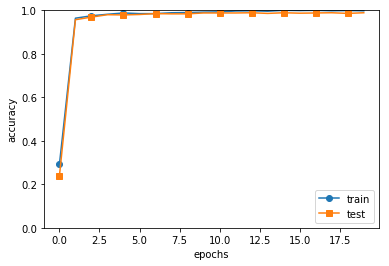

In [69]:

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()



## 7.6 CNNの可視化
* 畳み込み層を可視化することでCNNで何が行われているのかを探索する
### 7.6.1 1層目の重みの可視化

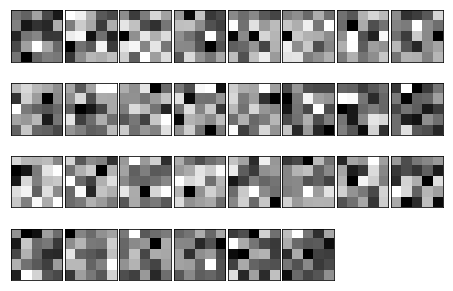

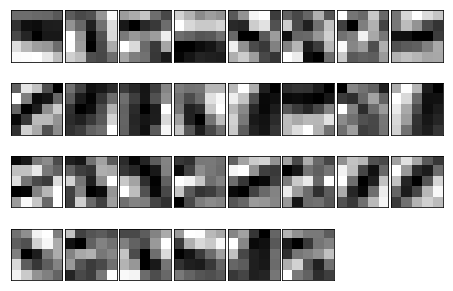

In [70]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))
    
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    
    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

### 7.6.2 階層構造による情報抽出
* 先の結果の考察
  * 1層目の畳み込み層を対象とした結果である
  * 1層目ではエッジやブロブなどの低レベルな情報が抽出される
  * ディープラーニングの可視化に関する研究では，層が深くなるに従い抽出される情報はより抽象化されていくことが示されている
    * AlexNetのネットワーク構成は畳み込み層とプーリング層が何層にも重なり，最後に全結合層を経て結果が出力される
  * 畳み込み層を何層も重ねると，層が深くなるにつれ，より複雑で抽象化された情報が抽出される
  * 最初の層は単純なエッジに反応し，次にテクスチャに反応し，そしてより複雑な物体のパーツへと反応するように変化する
    * 層が深くなるに従い，単純な形状から高度な情報へと変化する．
    * ものの意味を理解するかのように反応する対象が変化する．

## 7.7 代表的なCNN
* CNNは様々な構成のネットワークが提案されてきた
* LeNetおよびAlexNetは特に重要なネットワークである

### 7.7.1 LeNet
* CNNの元祖
* 手書き数字認識を行うネットワークとして1998年に提案された
* 畳み込み層とサブサンプリング層（要素を間引く層）を連続して行い，最後に全結合層を経て結果が出力される
* 現在のCNNとの違い
  * シグモイド関数が使われている（現在は主にReLUが使われる）
  * サブサンプリングによって中間データのサイズを縮小している（現在はMaxプーリングが主流） 

### 7.7.2 AlexNet
* ディープラーニングが注目されるに至ったCNN．2012年に提案された．
* 畳み込み層とプーリング層を重ね，最後に全結合層を経由して結果を出力する
* 基本構成はLeNetと変わらないが，以下の点で異なる
  * ReLUを使用する
  * LRN(Local Response Normalization)という局所的正規化の層を使用する
  * Dropoutを使用する
* LeNetの時代と比べるとコンピューティング環境が変化
  * 大量データの入手が容易になった
  * GPUが普及し，大量の演算を高速に実行可能となった

## 7.8 まとめ
* CNNについて学んだ
  * CNNを構成する基本モジュールは「畳み込み層」と「プーリング層」である
  * CNNはこれまでの全結合層のネットワークに加え，畳み込み層とプーリング層が加わったもの
  * CNNは画像を扱う分野では例外なく使われる
* 畳み込み層とプーリング層はim2colを用いるとシンプルで効率よく実装できる
* CNNの可視化により高度な情報が層を深くするにつれて抽出される様子がわかる
* ディープラーニングの発展にビックデータとGPUが大きく貢献している